<a href="https://colab.research.google.com/github/JainMridul82/Transliteration_Encoder_Decoder_Attention/blob/master/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import random
import re
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm import tqdm_notebook
from xml.etree.ElementTree import parse

In [2]:
device_gpu=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device_gpu)

cuda:0


In [3]:
eng_alphabets='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char='-PAD-'
eng_alpha2index={pad_char:0}
for index,alpha in enumerate(eng_alphabets):
  eng_alpha2index[alpha]=index+1
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [4]:
hindi_alphabets=[chr(alpha) for alpha in range(2304,2432)]
hindi_alphabets_size=len(hindi_alphabets)
hindi_alpha2index={pad_char:0}
for index,alpha in enumerate(hindi_alphabets):
  hindi_alpha2index[alpha]=index+1
print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [0]:
non_eng_letters_regex=re.compile('[^a-z A-Z]')

In [0]:
def cleanEnglishVocab(line):
  line=line.replace(',',' ').replace('-',' ').upper()
  line=non_eng_letters_regex.sub('',line)
  return line.split()

In [0]:
def cleanHindiVocab(line):
  line=line.replace('-',' ').replace(',',' ')
  cleaned_line=''
  for char in line:
    if char in hindi_alpha2index or char==' ':
      cleaned_line+=char
  return cleaned_line.split()

In [0]:
class Transliteration_Dataloader(Dataset):
  def __init__(self,filename):
    self.eng_words,self.hindi_words=self.readXmlDataset(filename)
    self.shuffle_start_index=0
    self.shuffle_indices=list(range(len(self.eng_words)))
    random.shuffle(self.shuffle_indices)
  def __len__(self):
    return len(self.eng_words)
  def __getitem__(self,idx):
    return self.eng_words[idx],self.hindi_words[idx]
  def readXmlDataset(self,filename):
    transliteration_corpus=parse(filename).getroot()
    lang1_list=[]
    lang2_list=[]
    for line in transliteration_corpus:
      lang1=cleanEnglishVocab(line[0].text)
      lang2=cleanHindiVocab(line[1].text)
      if len(lang1)!=len(lang2):
        print('Skipping',line[0].text,' - ',line[1].text)
        continue
      for data in lang1:
        lang1_list.append(data)
      for data in lang2:
        lang2_list.append(data)
    return lang1_list,lang2_list
  def get_sample_return(self):
    return self.__getitem__(np.random.randint(len(self.eng_words)))
  def get_batch_from_array(self,batch_size,array):
    batch=[]
    end=self.shuffle_start_index+batch_size
    if end>=len(self.eng_words):
      batch=[array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
      end=len(self.eng_words)
    return batch+[array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
  def get_batch(self,batch_size):
    batch1=self.get_batch_from_array(batch_size,self.eng_words)
    batch2=self.get_batch_from_array(batch_size,self.hindi_words)
    self.shuffle_start_index+=batch_size
    if self.shuffle_start_index>=len(self.eng_words):
      self.shuffle_start_index=0
      random.shuffle(self.shuffle_indices)
    return batch1,batch2

In [9]:
train_data=Transliteration_Dataloader('/content/rI58TOlAScioEuPBbOYh_NEWS2012TrainingEnHi13937-1563719470862.xml')
test_data=Transliteration_Dataloader('/content/njThAK0RQGeoOuE9rfwg_NEWS2012RefEnHi1000-1563719263404.xml')

Skipping BARHARWA JUNCTION  -  बरहरवा
Skipping STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping KING EDWARD VII  -  किंग एडवर्ड
Skipping DIBANG VALLEY  -  दिबंगवैली
Skipping ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping AZAMNAGAR ROAD  -  आज़मनगर
Skipping CAPE TOWN  -  केपटाउन
Skipping NEW ZEALAND  -  न्यूज़ीलैंड
Skipping SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping RAMCOIND  -  राम्को इंड
Skipping KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping JAHAN AARA  -  जहाँआरा
Skipping NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping FAKHRUN NISA  -  फखरुन्निसा
Skipping REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping OPENTV  -  ओपन टीवी
Skipping ENVOY COMMUNICATIONS GROUP  -  एन्वॉय कम्युनिकेशंस
Skipping WAR OF THE

In [0]:
def lang_rep(word,alpha2index,device='cpu'):
  rep=torch.zeros(len(word)+1,1,len(alpha2index)).to(device)
  for index,alpha in enumerate(word):
    pos=alpha2index[alpha]
    rep[index][0][pos]=1
  pad_pos=alpha2index[pad_char]
  rep[index+1][0][pad_pos]=1
  return rep

In [0]:
def gt_rep(word,alpha2index,device='cpu'):
  rep=torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
  for index,alpha in enumerate(word):
    rep[index][0]=alpha2index[alpha]
  rep[index+1][0]=alpha2index[pad_char]
  return rep

In [0]:
class Transliteration_EDA(torch.nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(Transliteration_EDA,self).__init__()
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.h2o=torch.nn.Linear(self.hidden_size,self.output_size)
    self.softmax=torch.nn.LogSoftmax(dim=2)
    self.encoder_rnn_cell=torch.nn.GRU(input_size,self.hidden_size)
    self.decoder_rnn_cell=torch.nn.GRU(self.hidden_size*2,self.hidden_size)
    self.o2h=torch.nn.Linear(self.output_size,self.hidden_size)
    self.attn=torch.nn.Linear(self.hidden_size,1)
    self.U=torch.nn.Linear(self.hidden_size,self.hidden_size)
    self.W=torch.nn.Linear(self.hidden_size,self.hidden_size)
  def forward(self,input_,max_output_chars,device='cpu',gt=None):
    e_out,hidden=self.encoder_rnn_cell(input_)
    e_out=e_out.view(-1,self.hidden_size)
    decoder_state=hidden
    decoder_input=torch.zeros(1,1,self.output_size).to(device)
    outputs=[]
    U=self.U(e_out)
    for i in range(max_output_chars):
      W=self.W(decoder_state.view(1,-1).repeat(e_out.shape[0],1))
      V=self.attn(torch.tanh(U+W))
      attn=F.softmax(V.view(1,-1),dim=1)
      attn_wts=torch.bmm(attn.unsqueeze(0),e_out.unsqueeze(0))
      embedding=self.o2h(decoder_input)
      decoder_input=torch.cat((embedding[0],attn_wts[0]),dim=1).unsqueeze(0)
      out,decoder_state=self.decoder_rnn_cell(decoder_input,decoder_state)
      out=self.h2o(decoder_state)
      out=self.softmax(out)
      outputs.append(out.view(1,-1))
      max_idx=torch.argmax(out,2,keepdim=True)
      if not gt is None:
        max_idx=gt[i].reshape(1,1,1)
      one_hot=torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)
      decoder_input=one_hot.detach()
    return outputs

In [0]:
def infer(net,input_,max_output_chars,device='cpu'):
  net=net.to(device)
  word=lang_rep(input_,eng_alpha2index,device)
  outs=net(word,max_output_chars,device,None)
  return outs

In [0]:
def train_batch(net,opt,criterion,batch_size,device='cpu',teacher_force=False):
  net=net.train().to(device)
  opt.zero_grad()
  total_loss=0
  eng,hindi=train_data.get_batch(batch_size)
  for i in range(batch_size):
    gt=gt_rep(hindi[i],hindi_alpha2index,device)
    word=lang_rep(eng[i],eng_alpha2index,device)
    outs=net(word,gt.shape[0],device,gt if teacher_force else None)
    for index,out in enumerate(outs):
      loss=criterion(out,gt[index])/batch_size
      loss.backward(retain_graph=True)
      total_loss+=loss
  opt.step()
  return total_loss/batch_size

In [0]:
def train_setup(net,lr,momentum,batch_size,n_batches,display_freq,device='cpu'):
  net=net.train().to(device)
  opt=torch.optim.Adam(net.parameters(),lr=lr)
  criterion=torch.nn.NLLLoss(ignore_index=-1)
  loss_arr=np.zeros(n_batches+1)
  #teacher_force_upto=n_batches//3
  for i in range(n_batches):
    loss_arr[i+1]=(loss_arr[i]*i+train_batch(net,opt,criterion,batch_size,device,True))/(i+1)
    if i%display_freq==display_freq-1:
      clear_output(wait=True)
      print('Iteration',i,'Loss',loss_arr[i])
      plt.figure()
      plt.plot(loss_arr[1:i],'-*')
      plt.xlabel('Iteration')
      plt.ylabel('Loss')
      plt.show()
  torch.save(net,'GRU_Att_Adam.pt')
  return loss_arr

Iteration 2047 Loss 0.03051852621138096


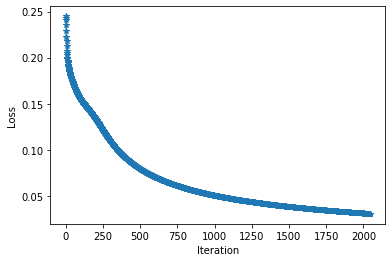

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Transliteration_EDA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net=Transliteration_EDA(len(eng_alpha2index),512,len(hindi_alpha2index))
loss_arr=train_setup(net,lr=0.001,momentum=0.9,batch_size=128,n_batches=2048,display_freq=2,device=device_gpu)

In [0]:
def test(net,input_,max_output_chars,device='cpu'):
  net=net.eval().to(device)
  word=lang_rep(input_,eng_alpha2index,device)
  outs=net(word,max_output_chars,device,None)
  hindi_output=''
  for out in outs:
    _,indices=out.topk(1)
    indices=indices.tolist()[0][0]
    if indices==0:
      break
    hindi_char=list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out))]
    hindi_output+=hindi_char
  print(input_,' - ',hindi_output)
  return hindi_output

In [0]:
def get_accuracy(net,device='cpu'):
  net=net.eval().to(device)
  accuracy=0
  for i in range(len(test_data)):
    eng,hindi=test_data[i]
    gt=gt_rep(hindi,hindi_alpha2index,device)
    word=lang_rep(eng,eng_alpha2index,device)
    correct=0
    outs=net(word,gt.shape[0],device,None)
    for index,out in enumerate(outs):
      _,indices=out.topk(1)
      indices=indices.tolist()[0][0]
      if indices==gt[index][0]:
        correct+=1
    accuracy+=correct/gt.shape[0]
  accuracy/=len(test_data)
  return accuracy

In [0]:
net=torch.load('/content/GRU_Att_Adam.pt')

In [20]:
test(net,'CANADA',15,device=device_gpu)

CANADA  -  कनाडा


'कनाडा'

In [21]:
get_accuracy(net,device_gpu)

0.7873035631035629